**Before you start:** Click **File → Save a copy in Drive** so you have your own version of this notebook. If you skip this step, your work will not be saved.

# Load modules and settings

In [1]:
# first thing is to import pandas
import pandas as pd

pd.options.display.max_columns = None
pd.options.display.max_rows = 20

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

# Load Maryland Data
Column meanings:
 - umd_id - Unique identifier for each arrestee
 - outcome_violent_rearrest -
     - `0` - arrestee was not rearrested with a violent charge
     - `1` - arrestee was rearrested with a violent charge
 - prediction - predicted probability of violent rearrest from a machine learning model 
 - n_vio_convictions__last_180_days - number of convictions for a violent crime in the last 180 days
 - n_vio_convictions__last_4_years - number of convictions for a violent crime in the last 4 years
 - n_vio_arrests__last_180_days - number of arrests for a violent crime in the last 180 days
 - n_vio_arrests__last_4_years - number of arrests for a violent crime in the last 4 years
 - age_at_arrest

In [2]:
lab5_data = pd.read_csv('https://www.dropbox.com/scl/fi/0nhbo32tdw7mi2v2g0vd0/lab5_dataset.csv?rlkey=e0oevkrciv91r53rricdesq00&dl=1')
lab5_data.head()

,umd_id,outcome_violent_rearrest,prediction,n_vio_convictions_last_4yrs,n_vio_convictions_last_180days,n_vio_arrests_last_4yrs,n_vio_arrests_last_180days,age_at_arrest
0,5974815,0.0,0.084093,0.0,0.0,0.0,0.0,35.060274
1,5835352,1.0,0.420702,0.0,0.0,0.0,0.0,19.717808
2,7222541,0.0,0.124549,0.0,0.0,0.0,0.0,56.427397
3,5031868,1.0,0.181424,0.0,0.0,0.0,0.0,25.186301
4,3532116,0.0,0.114881,0.0,0.0,0.0,0.0,28.764384


In [3]:
lab5_data.shape

(10000, 8)

# Reminder: Setting a threshold and performance metrics


<div>
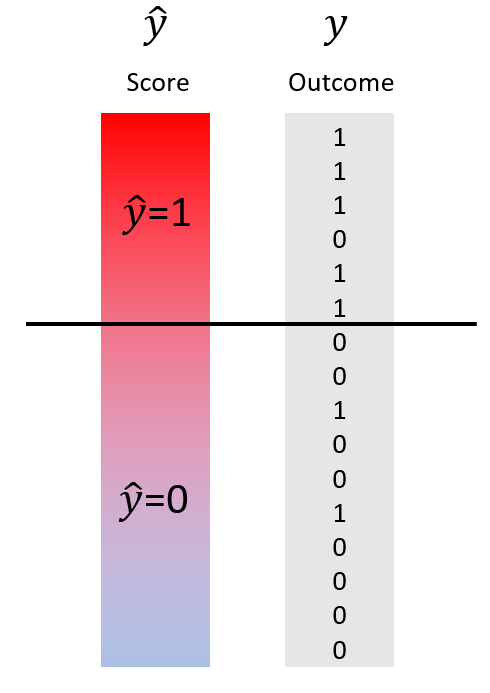
</div>


<div>
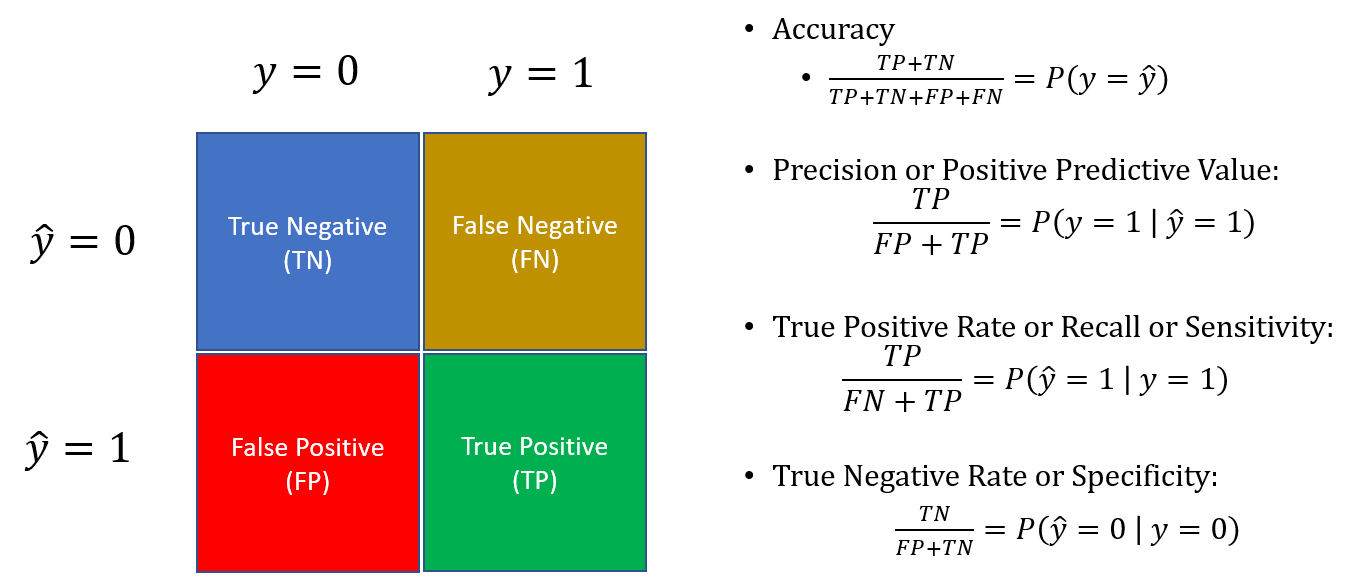
</div>


# Lab Task
## Performance Metrics
- Create a new column called `y` that is just a copy of the `outcome_violent_rearrest` column

- Create a new column called `yhat` that is True if the prediction column is greater than or equal to 0.5 and False otherwise

- Convert the `yhat` column to 0s and 1s using the `map` function 

- Use the `value_counts` function to compute the joint distribution of `y` and `yhat`

- Use the `y` and `yhat` columns to compute the True Positive Rate, or recall. i.e. $P(\hat{y}=1|y=1)$

- Use the `y` and `yhat` columns to compute the Positive Predictive Value (PPV), or precision. i.e. $P(y=1|\hat{y}=1)$

- Now create a new variable called `base_rate` which is equal to the overall rearrest rate. i.e. $P(y=1)$

- Create a new column called `yhat_new` that is 1 if the `prediction` column is greater than the `base_rate` and 0 otherwise

- Compute TPR and PPV using `yhat_new` and `y`. 
   - Compare the TPR and PPV values across the two thresholds that we created
   - Why did TPR go up and why did PPV go down?

- Here is another way we can set the threshold. Instead of using the predicted probabilities, we'll use the ranks. Sort the lab5_data DataFrame using the `predictions` column from highest to lowest

- What is the PPV for defendants with the top 500 predicted probabilities of violent rearrest. i.e. $P(y=1| rank ~of ~prediction \le 500)$

## Naive Bayes
We are now going to use the Naive Bayes algorithm to predict whether someone which is a young adult and has 1 or more prior conviction in the last 4 years is at high risk of being rearrested for a violent crime.

We are going to compare:

**P(y=1|young_adult=1, n_vio_convictions_last_4_years>1)**

vs.

**P(y=0|young_adult=1, n_vio_convictions_last_4_years>1)**

Have to apply Naive Bayes
<font color='blue' size=5>$P(A | B, C) = P(C|A) \cdot P(B|A) \cdot P(A) $</font>

Note that we are ignoring the denominator here (since this is Naive Bayes)

### Create a new column
- First create a new column called `young_adult` using the `between` function that is True when age at arrest is greater than or equal to 18 and less than or equal to 25. By default the between function treats the boundaries as inclusive.

### Compute the numerator for `y=1`

- Compute P(young_adult=1|y=1)

- Compute P(n_vio_convictions_last_4_years>1|y=1)

- Compute P(y=1)

- Compute the numerator

### Compute the numerator for `y=0`
- Compute P(young_adult=1|y=0)

- Compute P(n_vio_convictions_last_4_years>1|y=0)

- Compute P(y=0)

- Compute the numerator

### Now classify
- Use your results to decide how to classify someone who is a young adult and has 1 or more violent convictions in last 4 years.